In [1]:
import os
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import logging
import numpy as np

In [2]:
# Constants
group_code = "santiagomartinez_201533279_camilocastaneda_202314092"

In [3]:
mcs = [
    "scrooge",
    "dorian",
    "juliet",
    "prospero"
       ]

In [4]:
# Function to read and preprocess text from a folder
def read_input(folder_path):
    for root, _, files in os.walk(folder_path):
        for file_ in files:
            with open(os.path.join(root, file_), "r", encoding="utf-8") as f:
                for i, line in enumerate (f):
                    if (i%10000==0):
                        logging.info ("read {0} reviews".format (i))
                    yield gensim.utils.simple_preprocess(line)

def read_and_preprocess_text(data_file):
    return list (read_input(data_file))

# Function to train Word2Vec model
def train_word2vec_model(texts, embedding_size, group_code):
    model = Word2Vec(texts, vector_size=embedding_size, window=5, min_count=1, sg=0)
    model.train(texts,total_examples=len(texts), epochs=10)
    model.save(f"Books_{embedding_size}_{group_code}.model")

In [16]:
# Prepare the training dataset for each author
authors = os.listdir("book_datasets")
texts = []
for author in authors:
    author_folder = os.path.join("book_datasets")
    books = os.listdir(author_folder)
    texts_temp = read_and_preprocess_text(author_folder)
    texts += texts_temp
    
# Train Word2Vec models with different embedding sizes
embedding_sizes = [64, 128, 256]  # Adjust as needed
for size in embedding_sizes:
    train_word2vec_model(texts, size, group_code)

print("Word2Vec models trained and saved to disk.")

Word2Vec models trained and saved to disk.


In [5]:
# Function to reduce dimensionality to 2D using t-SNE
def reduce_to_2d_with_tsne(model):
    tsne = TSNE(n_components=2, random_state=42)
    word_vectors_2d = tsne.fit_transform(model.wv.vectors)
    return word_vectors_2d

# Plot the Word2Vec embeddings
def plot_word_embeddings(word_vectors_2d, model, main_characters): 
    plt.figure(figsize=(12, 8))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1])
    for i, word in enumerate(model.wv.index_to_key):
        if word in main_characters:
            plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1],))
    plt.title("Word Embeddings of Main Characters")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [34]:
embedding_size = 128
# Load the Word2Vec model for a specific book (replace "<size>" with the actual embedding size)
model = Word2Vec.load(f"Books_{embedding_size}_{group_code}.model")

# Find Similar Words
similar_words = {}
for character in mcs:
    similar_words[character] = [word for word, _ in model.wv.most_similar(character, topn=5)]

print("5 closest words to each character:")
for character, words in similar_words.items():
    print(f"{character}: {', '.join(words)}")

5 closest words to each character:
scrooge: sikes, fagin, bob, dodger, jew
dorian: harry, monks, hallward, mr, basil
juliet: romeo, nurse, montague, tybalt, farewell
prospero: discovers, exit, lawrence, theobald, malone


{'scrooge': ['sikes', 'fagin', 'bob', 'dodger', 'jew'], 'dorian': ['harry', 'monks', 'hallward', 'mr', 'basil'], 'juliet': ['romeo', 'nurse', 'montague', 'tybalt', 'farewell'], 'prospero': ['discovers', 'exit', 'lawrence', 'theobald', 'malone']}


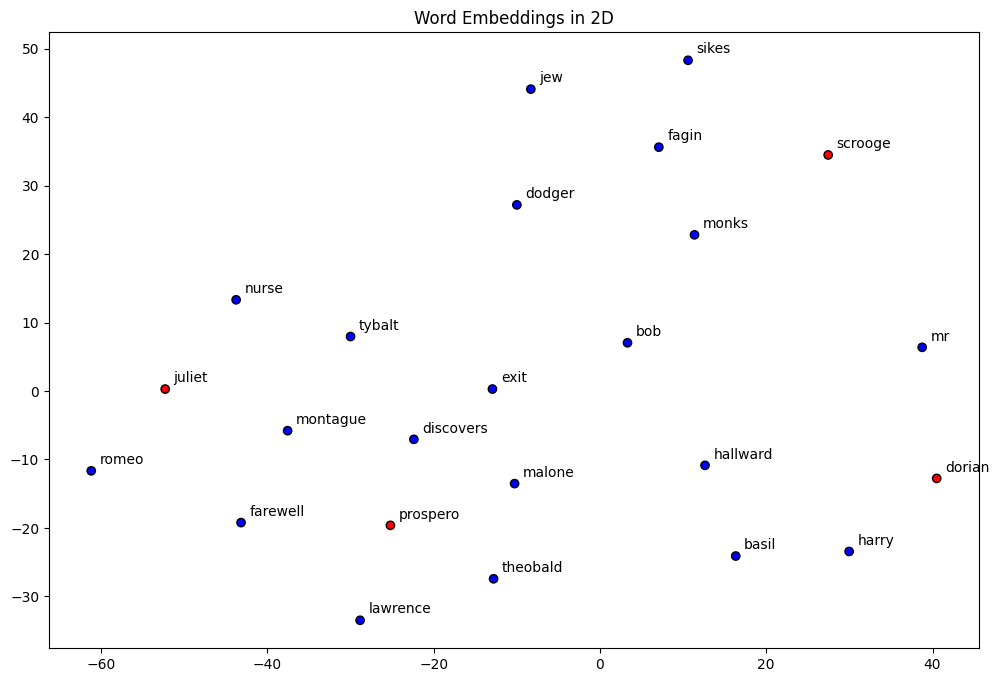

In [36]:
# Apply Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=11)

# Find Similar Words and store them in similar_words
similar_words = {character: [word for word, _ in model.wv.most_similar(character, topn=5)]
                   for character in mcs}

print(similar_words)

# Summarize similar words and their corresponding vectors
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [model.wv.key_to_index[w] for w in words]
word_vectors = np.array([model.wv.vectors[idx] for idx in words_ids])

# Create a list to specify if each word is a protagonist or not
protagonist_labels = [1 if word in mcs else 0 for word in words]

# Apply t-SNE transformation to the word vectors
T = tsne.fit_transform(word_vectors)

# Plot the Word Embeddings
plt.figure(figsize=(12, 8))
# Define colors: blue for non-protagonists and red for protagonists
colors = ['blue' if label == 0 else 'red' for label in protagonist_labels]
plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k')

for label, x, y in zip(words, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

plt.title("Word Embeddings in 2D")
plt.show()

La técnica de reducción de dimensionalidad t-SNE, que significa "t-distributed Stochastic Neighbor Embedding" o "Incrustación Estocástica de Vecinos Distribuidos en t", es una herramienta valiosa en el campo de la ciencia de datos y el aprendizaje automático para abordar el problema de visualización de datos de alta dimensionalidad. A través de este método, los datos multidimensionales complejos se transforman en un espacio de menor dimensión, generalmente 2D, mientras se intenta preservar la estructura y similitudes intrínsecas entre los puntos de datos originales. 

El proceso detrás de t-SNE se basa en la idea de que los datos de alta dimensión se asemejan a una distribución de probabilidad conjunta en un espacio de alta dimensión. Lo que t-SNE hace es mapear esta distribución a un espacio de menor dimensión, generalmente 2D, de manera que los puntos que son similares en la distribución original sigan siendo similares en el nuevo espacio. Para lograr esto, t-SNE minimiza la diferencia entre las probabilidades conjuntas en los espacios de alta y baja dimensión.

El parámetro clave en t-SNE es la "perplexidad", que puede entenderse como una medida de cuántos vecinos cercanos debe considerar el algoritmo al construir la distribución de probabilidad en el espacio de alta dimensión. Una baja perplexidad hace que el algoritmo se concentre más en los vecinos cercanos, mientras que una alta perplexidad considera un mayor número de vecinos. Esto permite controlar el equilibrio entre la compresión de detalles finos y la captura de estructuras más amplias en los datos.

El proceso de t-SNE implica iteraciones para ajustar los puntos en el espacio de menor dimensión hasta que se logre una representación óptima. Este proceso puede llevar tiempo y esfuerzo computacional, pero el resultado es una visualización que refleja de manera efectiva las relaciones entre los datos originales.